# Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
from matplotlib.pylab import rcParams
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
uni_final = pd.read_csv('data/uni_final.csv')

Use visualizations to get a guess of stationarity.  
Then, use the rolling mean/std for a good visualization  
Back it up with a Dickey-Fuller test (Null: The data is NOT stationary) 

In [3]:
uni_final.head()

,ValidDate,Sum
0,2014-12-02,82
1,2014-12-03,232
2,2014-12-04,351
3,2014-12-05,163
4,2014-12-08,337


In [4]:
uni_final.set_index('ValidDate', inplace = True)

In [5]:
uni_final.index = pd.to_datetime(uni_final.index)

In [6]:
#Just some exploration to satisfy curiosity
uni_final.resample('m')['Sum'].mean()

ValidDate
2014-12-31     892.857143
2015-01-31    2361.550000
2015-02-28     596.263158
2015-03-31     244.136364
2015-04-30     336.681818
2015-05-31     181.800000
2015-06-30      92.545455
2015-07-31      70.272727
2015-08-31      60.000000
2015-09-30      55.476190
2015-10-31      45.523810
2015-11-30     258.736842
2015-12-31    2073.954545
2016-01-31     892.736842
2016-02-29     343.850000
2016-03-31     208.608696
2016-04-30     147.428571
2016-05-31     133.095238
2016-06-30     205.590909
2016-07-31      91.450000
2016-08-31      60.130435
2016-09-30      45.761905
2016-10-31      36.650000
2016-11-30      30.150000
2016-12-31    1843.000000
2017-01-31    1071.800000
2017-02-28     359.631579
2017-03-31     202.000000
2017-04-30     243.400000
2017-05-31     253.045455
2017-06-30     108.045455
2017-07-31      72.750000
2017-08-31      62.565217
2017-09-30      40.100000
2017-10-31      35.047619
2017-11-30      10.950000
2017-12-31       0.400000
Freq: M, Name: Sum, dtype: f

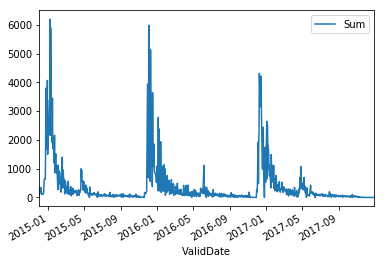

In [7]:
uni_final.plot()

I'm gonna go out on a limb and say this is not stationary- it's periodic. 

In [8]:
roll_mean = uni_final.rolling(window = 30, center = False).mean()
roll_std = uni_final.rolling(window = 30, center = False).std()

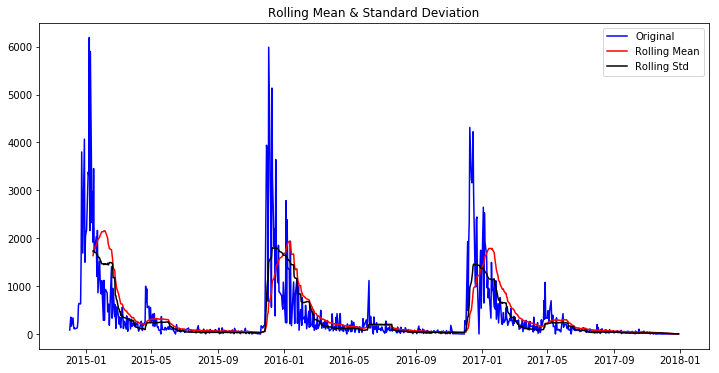

In [9]:
fig = plt.figure(figsize=(12,6))
plt.plot(uni_final, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

This is noisy, but does support the assumption that the data is not stationary. Neither the mean nor the standard deviation are constant over time. We will still conduct a Dickey-Fuller test to have a concrete comparison. 

In [10]:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(uni_final['Sum'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                  -4.734669
p-value                          0.000072
#Lags Used                      16.000000
Number of Observations Used    757.000000
Critical Value (1%)             -3.439018
Critical Value (5%)             -2.865366
Critical Value (10%)            -2.568807
dtype: float64


p<0.05, T-test<all critical values  
This data is NOT stationary  
Beginning removing trend by differencing by a period of 1, 3, 5, 10 and 20 days:  

Results of Dickey-Fuller Test (1 Days Difference): 

Test Statistic                -8.909043e+00
p-value                        1.117225e-14
#Lags Used                     1.800000e+01
Number of Observations Used    7.540000e+02
Critical Value (1%)           -3.439053e+00
Critical Value (5%)           -2.865381e+00
Critical Value (10%)          -2.568815e+00
dtype: float64
Results of Dickey-Fuller Test (3 Days Difference): 

Test Statistic                -8.352157e+00
p-value                        2.974631e-13
#Lags Used                     2.000000e+01
Number of Observations Used    7.500000e+02
Critical Value (1%)           -3.439099e+00
Critical Value (5%)           -2.865401e+00
Critical Value (10%)          -2.568826e+00
dtype: float64
Results of Dickey-Fuller Test (5 Days Difference): 

Test Statistic                -8.978601e+00
p-value                        7.414850e-15
#Lags Used                     2.000000e+01
Number of Observations Used    7.480000e+02
Critical Value (1%)

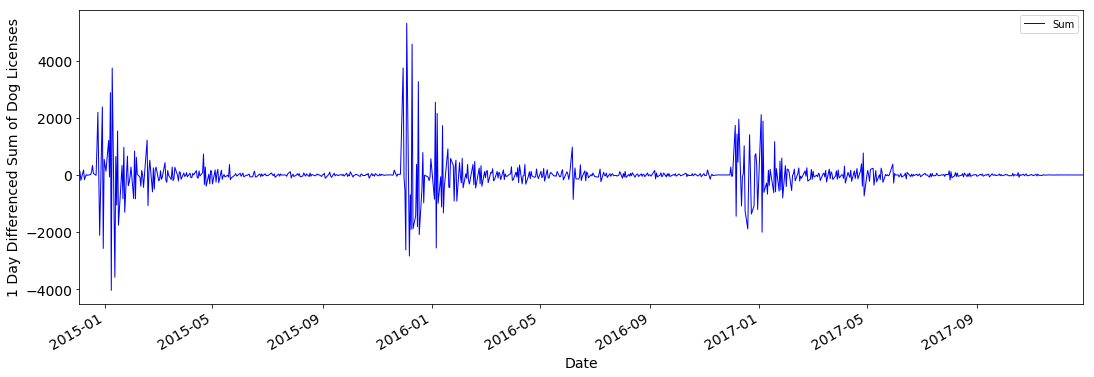

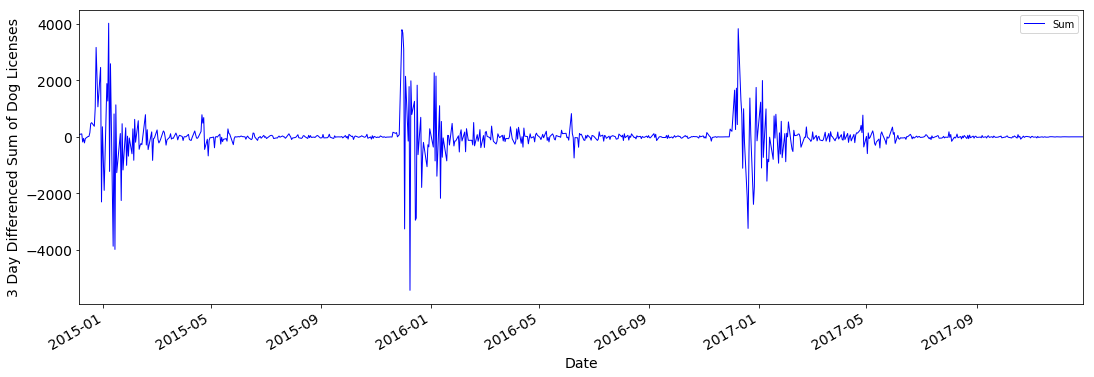

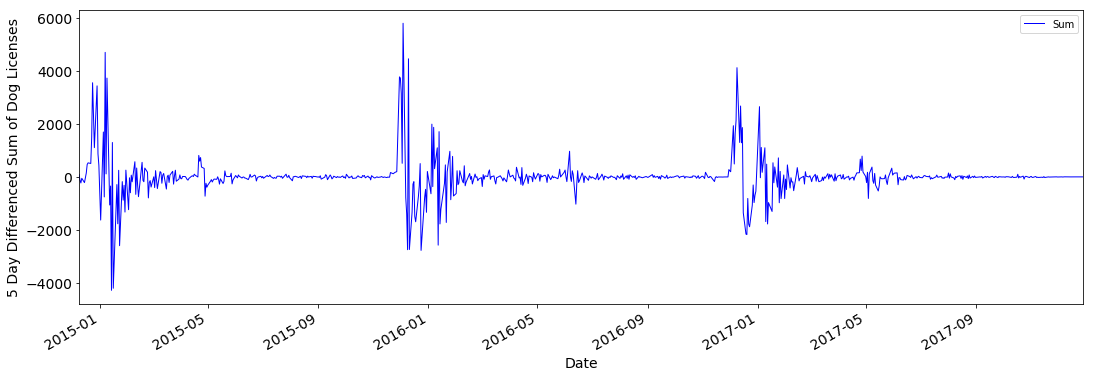

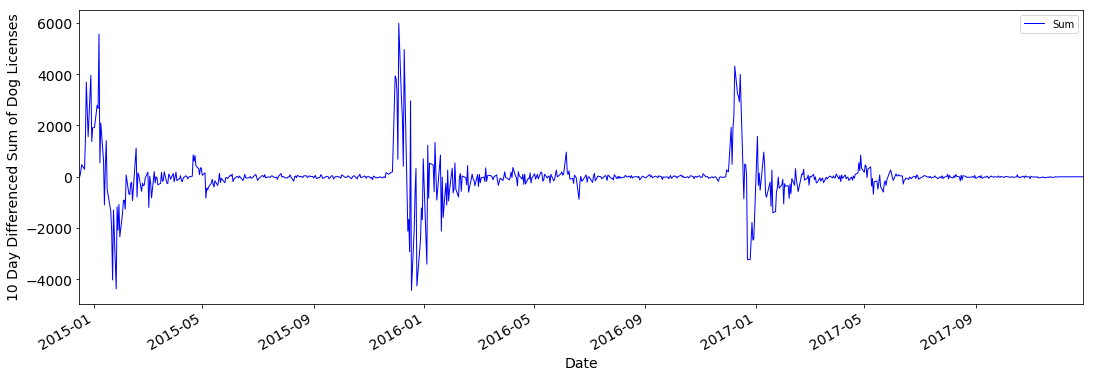

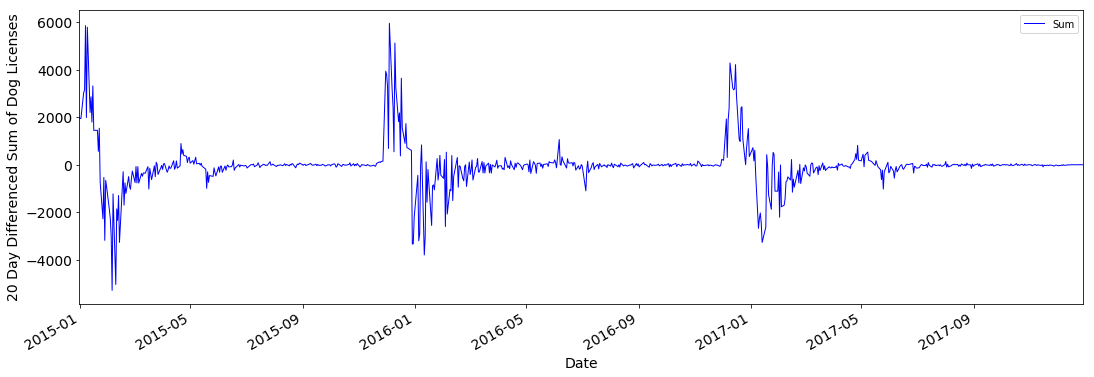

In [11]:
for days in [1, 3, 5, 10, 20]:
    uni_diff = uni_final.diff(periods= days)
    #Delete the null created by differencing
    uni_diff.dropna(inplace = True)
    uni_diff.plot(figsize=(18,6), color='blue', linewidth=1, fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(f'{days} Day Differenced Sum of Dog Licenses', fontsize=14)
    
    print (f'Results of Dickey-Fuller Test ({days} Days Difference): \n')
    dftest = adfuller(uni_diff['Sum'])

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

If I HAD to choose one, I suppose I would go with a one day difference just based on a visual analysis. But even that is not stationary. I'll try to log transform the data, and see which model is the most stationary. 

In [12]:
uni_diff_1  = uni_final.diff(periods= 1)
uni_diff_1.dropna(inplace = True)

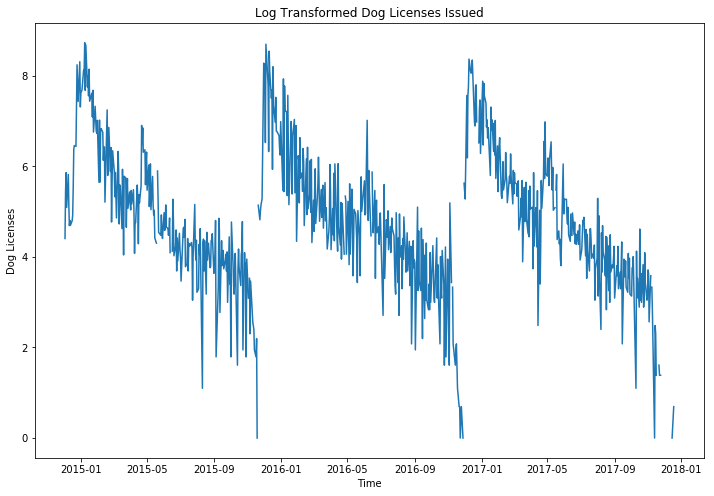

In [13]:
uni_log = pd.DataFrame(np.log(uni_final), index=uni_final.index)
fig = plt.figure(figsize = (12, 8))
plt.plot(uni_log)
plt.xlabel('Time')
plt.ylabel('Dog Licenses')
plt.title('Log Transformed Dog Licenses Issued')
plt.show()

Interesting.... let's run a Dickey-Fuller and see what happens  
Dickey-Fuller can't run due to the presence of -inf values in the Sum column. 

In [14]:
uni_log.isnull().sum()

Sum    0
dtype: int64

In [15]:
uni_log['Sum'].head()

ValidDate
2014-12-02    4.406719
2014-12-03    5.446737
2014-12-04    5.860786
2014-12-05    5.093750
2014-12-08    5.820083
Name: Sum, dtype: float64

In [16]:
print ('Results of Dickey-Fuller Test (Log Transform): \n')
dftest = adfuller(uni_log['Sum'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Results of Dickey-Fuller Test (Log Transform): 



MissingDataError: exog contains inf or nans

Based on available data and tests, an ARIMA model may not be appropriate. Pending research, I may attempt one using a one day differencing method. But it should be noted that this will likely not produce an accurate model.  

Before I look into ARIMA without stationarity, let's try one more thing- seasonal decomposition. The residuals may be stationary. 

In [17]:
uni_diff_1.index = pd.to_datetime(uni_diff_1.index)

In [18]:
uni_decomposition = seasonal_decompose(uni_diff_1, model = 'additive', freq = 251)
#note: freq = 251 because 365 days, minus weekends and holidays

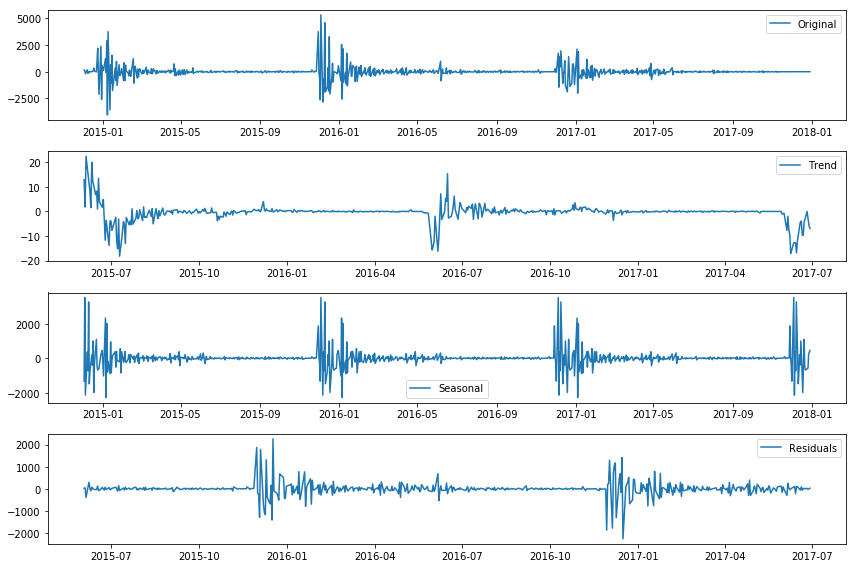

In [19]:
trend = uni_decomposition.trend
seasonal = uni_decomposition.seasonal
residuals = uni_decomposition.resid

plt.figure(figsize = (12, 8))
plt.subplot(411)
plt.plot(uni_diff_1, label = 'Original')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residuals, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

The residuals don't look stationary, but in the interest of being thorough, let's run a Dickey-Fuller test just to be sure. 

In [20]:
residuals.isnull().sum()

250

In order to make the residuals work I'd have to drop a full year of data. And that's IF it's even stationary. Let's just take a look. 

In [21]:
residuals.dropna(inplace = True)

In [25]:
print ('Results of Dickey-Fuller Test (Residuals): \n')
dftest = adfuller(residuals)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test (Residuals): 

Test Statistic                -8.345392e+00
p-value                        3.095395e-13
#Lags Used                     1.800000e+01
Number of Observations Used    5.040000e+02
Critical Value (1%)           -3.443392e+00
Critical Value (5%)           -2.867292e+00
Critical Value (10%)          -2.569833e+00
dtype: float64


This data is not stationary. 

Results of ARIMA model without stationarity research:  
I do not think that attempting an ARIMA would be inappropriate, but it should definitely carry a disclaimer. 

## ARIMA Model and Forecasting

1. Generate p,d,q parameters, include s for SARIMA model
2. use grid search and SARIMAX to determine best pdq combo (lowest AIC)
3. use pdq to fit SARIMA model
4. Plot diagnostics
5. If by some miracle it passes, validate model and move on to forecasting

In [26]:
plt.style.use('ggplot')

In [27]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 251) for x in list(itertools.product(p, d, q))]

In [28]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(uni_final,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}251 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 251)251 : AIC Calculated =12631.631266256361
ARIMA (0, 0, 0) x (0, 0, 1, 251)251 : AIC Calculated =13345.572575177723
ARIMA (0, 0, 0) x (0, 1, 0, 251)251 : AIC Calculated =8584.340697116333
ARIMA (0, 0, 0) x (0, 1, 1, 251)251 : AIC Calculated =4317.446675664156
ARIMA (0, 0, 0) x (1, 0, 0, 251)251 : AIC Calculated =8302.87586794064
ARIMA (0, 0, 0) x (1, 0, 1, 251)251 : AIC Calculated =15770.098429452453
ARIMA (0, 0, 0) x (1, 1, 0, 251)251 : AIC Calculated =4391.812695800893
ARIMA (0, 0, 0) x (1, 1, 1, 251)251 : AIC Calculated =4316.747366340576
ARIMA (0, 0, 1) x (0, 0, 0, 251)251 : AIC Calculated =12353.90894225295
ARIMA (0, 0, 1) x (0, 0, 1, 251)251 : AIC Calculated =33574.92703336927
ARIMA (0, 0, 1) x (0, 1, 0, 251)251 : AIC Calculated =8438.535005737776
ARIMA (0, 0, 1) x (0, 1, 1, 251)251 : AIC Calculated =4214.277216062682
ARIMA (0, 0, 1) x (1, 0, 0, 251)251 : AIC Calculated =8164.5903994908795
ARIMA (0, 0, 1) x (1, 0, 1, 251)251 : AIC Calculated =33635.4

Find optimal PDQS based on lowest AIC value: 

In [29]:
ans_df = pd.DataFrame(ans, columns = ['pdq', 'pdqs', 'AIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

pdq          (1, 1, 1)
pdqs    (1, 0, 1, 251)
AIC            1987.42
Name: 61, dtype: object

Fit SARIMA model using PDQ of (1, 1, 1) and PDQS of (1, 0, 1, 251)

In [30]:
sarima = sm.tsa.statespace.SARIMAX(uni_final,
                                  order = (1, 1, 1),
                                  seasonal_order = (1, 0, 1, 251),
                                  enforce_stationarity = False,
                                  enforce_invertability = False)
output = sarima.fit()
print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1234      0.026     -4.680      0.000      -0.175      -0.072
ma.L1         -0.5685      0.023    -24.901      0.000      -0.613      -0.524
ar.S.L251     -0.0044      0.032     -0.140      0.889      -0.067       0.058
ma.S.L251      0.2195      0.040      5.428      0.000       0.140       0.299
sigma2       1.55e+05   3463.606     44.764      0.000    1.48e+05    1.62e+05


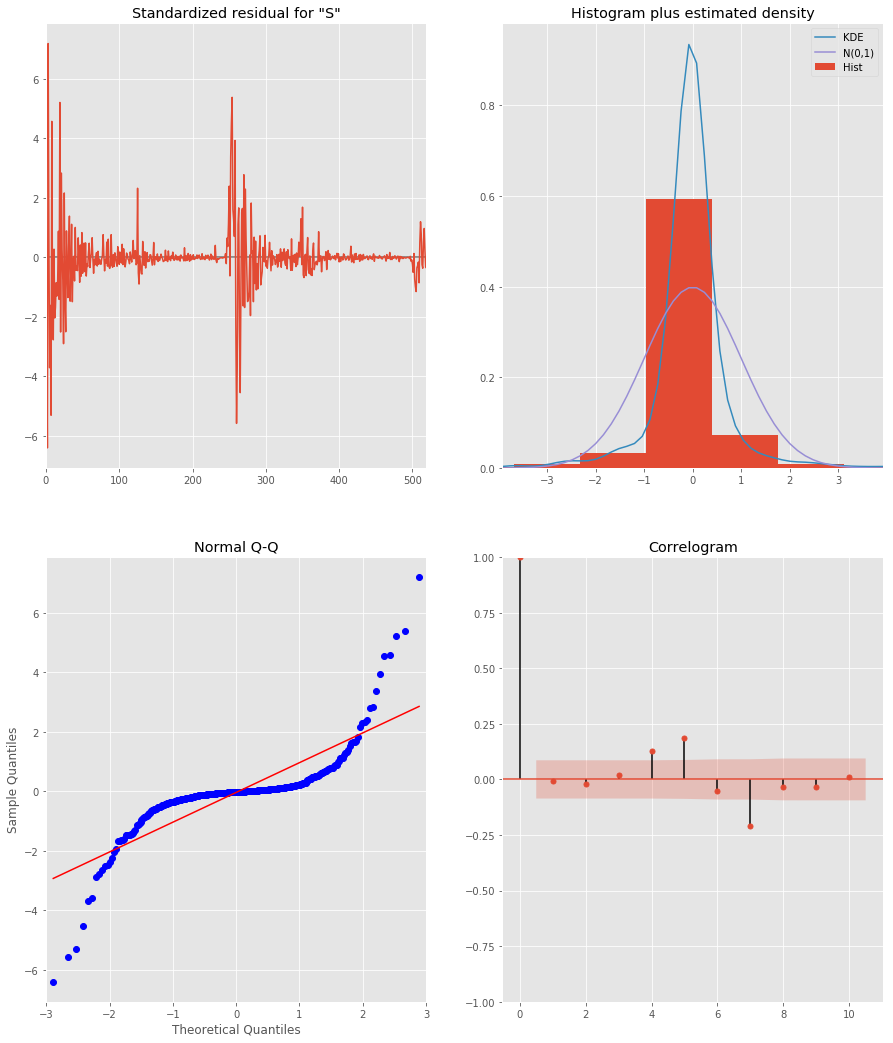

In [31]:
output.plot_diagnostics(figsize = (15, 18))
plt.show()

Based on these diagnostics, the residuals are still very seasonal. This is going to affect our forecast. Any predictions made should definitely be taken with a grain of salt. We will be able to see how reliable these predictions are by comparing predictions made against observed data. 

In [32]:
pred = output.get_prediction(start = pd.to_datetime('2014-12-02'), dynamic = False)
pred_conf = pred.conf_int()

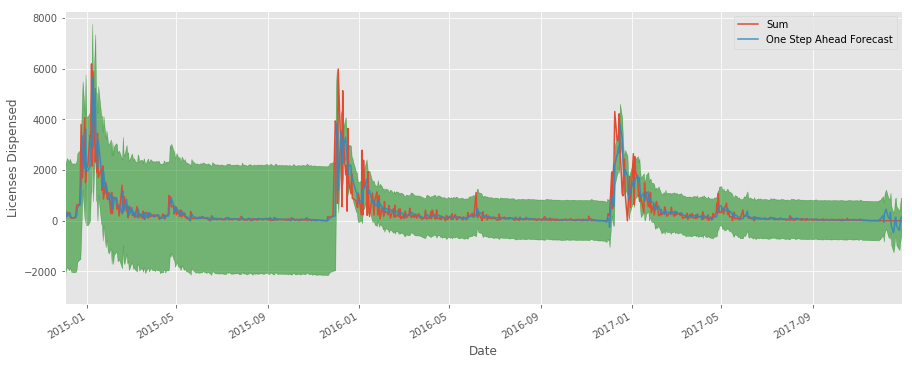

In [33]:
rcParams['figure.figsize'] = 15, 6

ax = uni_final.plot(label = 'Observed')
pred.predicted_mean.plot(ax = ax, label = 'One Step Ahead Forecast', alpha = 0.9)

ax.fill_between(pred_conf.index,
               pred_conf.iloc[:, 0],
               pred_conf.iloc[:, 1], color = 'g', alpha = 0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Licenses Dispensed')
plt.legend()
plt.show()

Look at that confidence interval... These predictions are definitely not very reliable. It is interesting to note, however, that the confidence interval seems to decrease in each subsequent year. The model may be learning to "expect the unexpected".  They follow the observed line fairly well, but there is a huge margin of error. The MSE may give us a little more clarity. 

In [34]:
uni_forecast = pd.DataFrame(pred.predicted_mean)
uni_observed = uni_final['2014-12-02':]

mse = ((uni_forecast['predicted_mean'] - uni_observed['Sum']) ** 2).mean()
print('MSE of our forecast is: {}'.format(round(mse, 2)))

MSE of our forecast is: 258643.45


This is a pretty large MSE. In this case, the MSE means that over the course of 3 years, the predictions were off by 258,643 licenses. I will make some predictions based on the data, but due to the nature of the data presented, these predictions will not be reliable. 

In [35]:
pred_dynamic = output.get_prediction(start = pd.to_datetime('2014-12-02'), dynamic = True, full_results = True)
pred_dynamic_conf = pred_dynamic.conf_int()

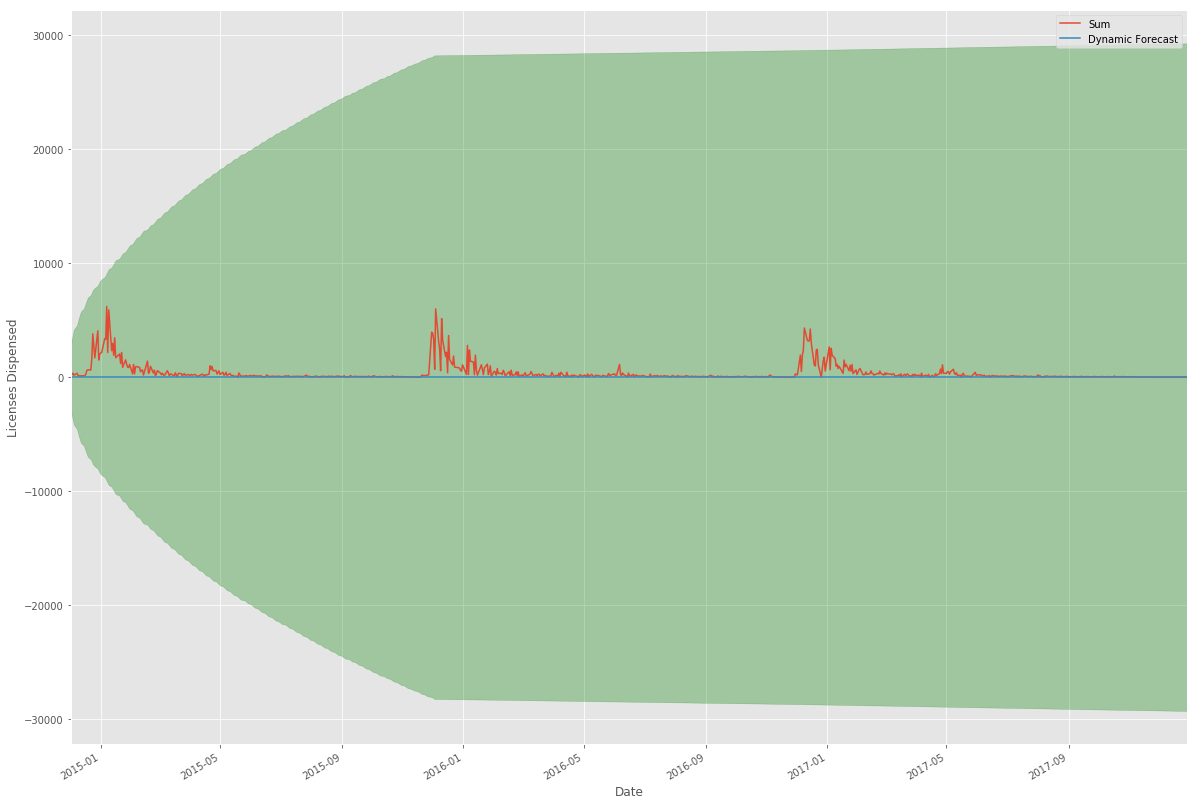

In [36]:
ax = uni_final.plot(label = 'Observed', figsize = (20,15))
pred_dynamic.predicted_mean.plot(label = 'Dynamic Forecast', ax = ax)


ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)
ax.set_ylabel('Licenses Dispensed')
ax.set_xlabel('Date')
plt.legend()
plt.show()

With such a huge confidence interval, I'm hesitant to even consider dynamic prediction in any kind of conclusions or recommendations within the scope of this project. This is further cemented by the MSE, which is 2.8 times higher than the original forecast. Dynamic forecasting is definitely not the way to go for this dataset. 

In [37]:
dynamic_forecast = pd.DataFrame(pred_dynamic.predicted_mean)
dynamic_observed = uni_final['2014-12-02':]

mse = ((dynamic_forecast['predicted_mean'] - dynamic_observed['Sum']) ** 2).mean()
print('The dynamic MSE is {}'.format(round(mse, 2)))

The dynamic MSE is 728908.43


Well this has been... eye opening. Let's generate one year of predictions, just to say we did. It's not necessarily a bad idea. It just shouldn't be used to make huge decisions. 

In [38]:
prediction = output.get_forecast(steps = 251)
pred_conf = prediction.conf_int()

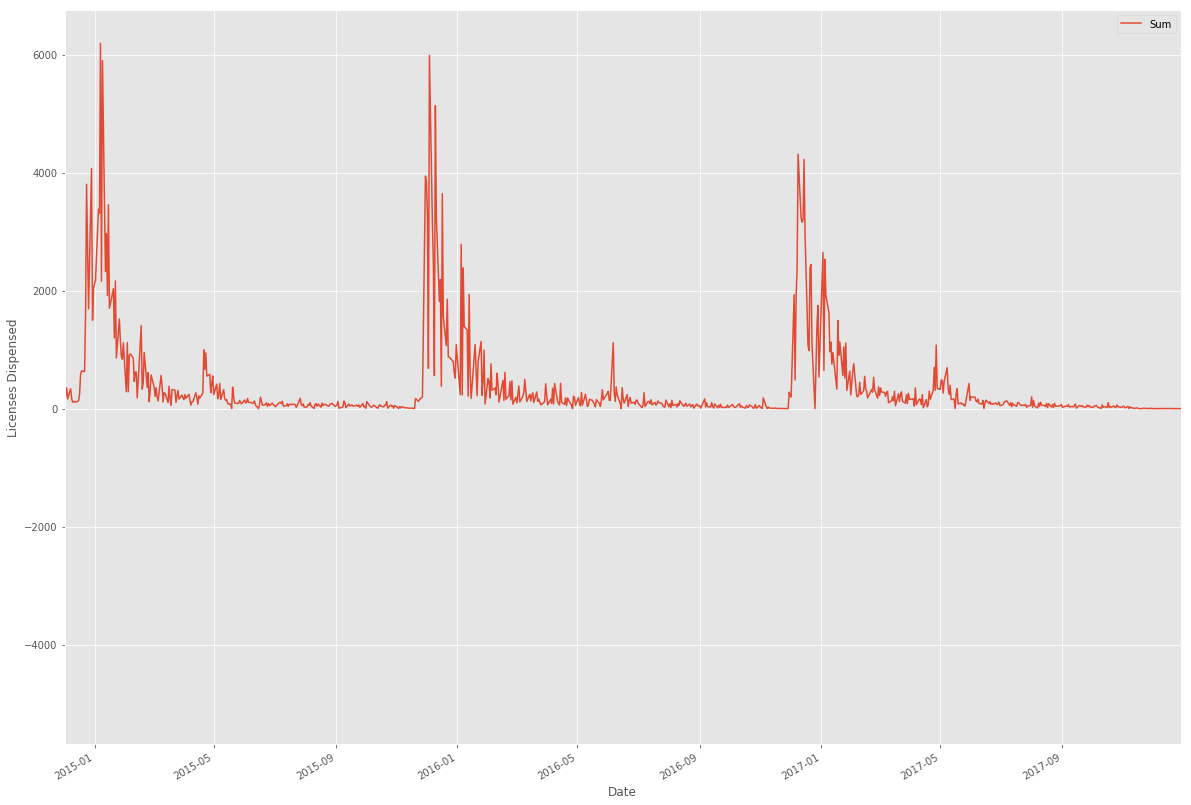

In [39]:
ax = uni_final.plot(label = 'Observed', figsize = (20, 15))
# prediction.predicted_mean.plot(ax=ax, label = 'Forecast')

ax.fill_between(pred_conf.index,
               pred_conf.iloc[:,0],
               pred_conf.iloc[:,1], color = 'g', alpha = 0.3)
ax.set_ylabel('Licenses Dispensed')
ax.set_xlabel('Date')
plt.legend()
plt.show()

A brief overview of the error:  
The "prediction" variable is generated on steps, ie, the index of the prediction.predicted_mean starts at 770(ish), and each step is a new row. Because I am trying to plot it against a date time index, I will need to create a new dataframe for the forecast.  
1. Create a dataframe with a datetime index  
2. Remove weekends and holidays (like in the test data)  
3. Cut this dataframe down to 251 steps  
4. Add in prediction.predicted_mean values 

In [40]:
df_forecast = pd.DataFrame({'ValidDate': pd.date_range(start = '2017-12-22', end = '2018-12-20', freq = 'B')})

In [41]:
df_forecast.head()

,ValidDate
0,2017-12-22
1,2017-12-25
2,2017-12-26
3,2017-12-27
4,2017-12-28


Holidays in the forecast: 2017-12-25, 2018-01-01, 2018-01-15, 2018-02-19, 2018-05-28, 2018-07-04, 2018-09-03, 2018-11-12, 2018-11-22

In [42]:
df_forecast = df_forecast[(df_forecast['ValidDate'] != '2017-12-25') &
                          (df_forecast['ValidDate'] != '2018-01-01') &
                          (df_forecast['ValidDate'] != '2018-01-15') &
                          (df_forecast['ValidDate'] != '2018-02-19') &
                          (df_forecast['ValidDate'] != '2018-05-28') &
                          (df_forecast['ValidDate'] != '2018-07-04') &
                          (df_forecast['ValidDate'] != '2018-09-03') &
                          (df_forecast['ValidDate'] != '2018-11-12') &
                          (df_forecast['ValidDate'] != '2018-11-22')]

In [43]:
df_forecast.set_index('ValidDate', inplace = True)

In [44]:
len(df_forecast)

251

In [45]:
forecast = pd.DataFrame(prediction.predicted_mean)

In [46]:
len(forecast)

251

In [47]:
forecast.set_index(df_forecast.index, inplace = True)

In [48]:
forecast.head()

,predicted_mean
ValidDate,
2017-12-22,-137.257858
2017-12-26,191.154291
2017-12-27,-123.593872
2017-12-28,189.136063
2017-12-29,93.548823


Because the pred_conf variable is based off the prediction variable, I will need to repeat the above steps in order to plot the confidence interval against the graph. 

In [49]:
pred_conf_df = pd.DataFrame(pred_conf)

In [50]:
pred_conf_df.set_index(df_forecast.index, inplace = True)

In [51]:
pred_conf_df[-5:]

,lower Sum,upper Sum
ValidDate,,
2018-12-14,-5028.003885,4392.020136
2018-12-17,-4986.019765,4452.640103
2018-12-18,-5030.620987,4426.638006
2018-12-19,-5074.532174,4401.289427
2018-12-20,-5094.037228,4400.310562


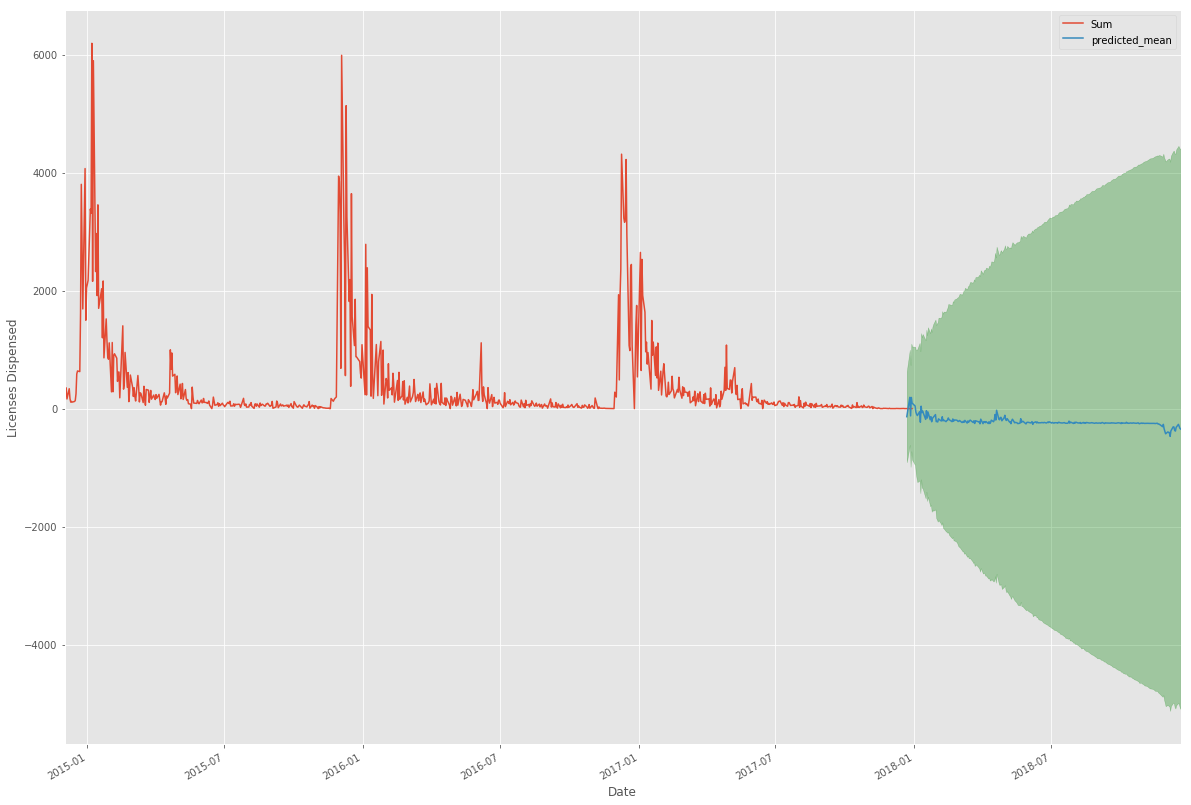

In [52]:
ax = uni_final.plot(label = 'Observed', figsize = (20, 15))
forecast.plot(ax = ax, label = 'Forecast')

ax.fill_between(pred_conf.index,
               pred_conf_df.iloc[:, 0],
               pred_conf_df.iloc[:, 1], color = 'g', alpha = 0.3)
ax.set_ylabel('Licenses Dispensed')
ax.set_xlabel('Date')
plt.legend()
plt.show()

It is interesting to note that the forecast does not handle the observed end-of-year/beginning-of-year spikes that we see in the observed data. This is most likely due to the absense of stationarity. Further research would definitely include an investigating why these spikes are occuring.  
To my untrained eye, I wonder if there are more people who procrastinate (the spike in December) and the exact opposite- people who realize they need to re-license their pet in a given year and choose to do it in January.  
Another possibility is that when an exact time is not available, a technician may be simply inputting the beginning or end of whichever year they are currently in. 

Calculate MSE against actual data:  
Start by cleaning our 2018 recorded data

In [54]:
df_18 = pd.read_csv('data/2018 Dog Licenses.csv')

In [55]:
df_18['ValidDate'] = pd.to_datetime(df_18['ValidDate'], format = '%Y-%m-%dT%H:%M:%S')

In [56]:
df_18.set_index('ValidDate', inplace = True)

In [57]:
df_18_uni = pd.DataFrame(df_18['LicenseType'])

In [58]:
df_18_uni.head()

,LicenseType
ValidDate,
2017-11-27 09:57:49,Dog Individual Neutered Male
2017-11-27 10:03:33,Dog Senior Citizen or Disability Neutered Male
2017-11-27 10:03:33,Dog Senior Citizen or Disability Male
2017-11-27 10:04:57,Dog Individual Neutered Male
2017-11-27 10:06:25,Dog Individual Neutered Male


In [59]:
df_18_uni['Sum'] = 1

In [60]:
df_18_uni_grouped = df_18_uni.resample('B').sum()

In [61]:
df_18_uni_grouped.head()

,Sum
ValidDate,
2017-11-27,169
2017-11-28,2241
2017-11-29,1712
2017-11-30,4212
2017-12-01,427


In [62]:
df_18_final = df_18_uni_grouped[(df_18_uni_grouped.index != '2017-12-25') &
                          (df_18_uni_grouped.index != '2018-01-01') &
                          (df_18_uni_grouped.index != '2018-01-15') &
                          (df_18_uni_grouped.index != '2018-02-19') &
                          (df_18_uni_grouped.index != '2018-05-28') &
                          (df_18_uni_grouped.index != '2018-07-04') &
                          (df_18_uni_grouped.index != '2018-09-03') &
                          (df_18_uni_grouped.index != '2018-11-12') &
                          (df_18_uni_grouped.index != '2018-11-22')]

In [63]:
df_18_final = df_18_final.head(251)

In [64]:
len(df_18_final)

251

In [65]:
df_18_final.to_csv(r'c:/Users/kayce_000/Flatiron School/Capstone Project/Dog Licenses\df_18_final.csv', index=True)

Calculate MSE between forecast and recorded data: 

In [66]:
mse = ((forecast['predicted_mean'] - df_18_final['Sum']) ** 2).mean()
print('The forecast MSE is {}'.format(round(mse, 2)))

The forecast MSE is 266774.51


The last thing I want to do is set the negative forecast values equal to zero- you can't dispense negative licenses in a day. This may bring our MSE down, and will help to form predictions.  
It is noteworthy that our MSE for the forecasted data is one of the smallest ones tested- even predicting against known data yielded an MSE of 258,643, only slightly lower than this one.  

In [67]:
forecast.loc[forecast['predicted_mean'] < 0, 'predicted_mean'] = 0

In [68]:
forecast['predicted_mean'].value_counts()

0.000000      246
93.548823       1
191.154291      1
40.677085       1
189.136063      1
44.859388       1
Name: predicted_mean, dtype: int64

In [69]:
mse = ((forecast['predicted_mean'] - df_18_final['Sum']) ** 2).mean()
print('The zeroed forecast MSE is {}'.format(round(mse, 2)))

The zeroed forecast MSE is 145107.43


This did reduce the MSE quite a lot. This is the number I'll use in my interpretation, not because it's "better" but because you can't dispense negative licenses in a day.  
This is actually the lowest MSE that our SARIMA model yields. I would still hesitate to make concrete decisions based on this prediction, but our model actually seems to forecast more accurately than it predicts against known data. Of course, a reason for this may be that the 2018 dataset was very thin - a reason that it is not used in our training data set. If a datapoint is missing, it's recorded as 0, but so is a negative value. According to our MSE model... the SARIMA model predicted correctly. 

## Conclusions/ Interpretation

* Because this data is very obviously seasonal, it is best practice to use a SARIMA model. For this investigation, I chose to use a grid search to optimize my values of p,d,q, and s. 
* Dynamic forecasting is definitely not the way to go with this dataset. This produced the highest MSE (predicted against known data) of this entire project. If we are making predictions against known data, it is best to set dynamic = False. 
* SARIMA actually did quite well against known data. Although this may be due to flaws in the data, I think it would definitely merit further investigation into the input of the data (explaining spikes in December and January.) This model performed surprisingly well against previously unseen observed data. 
* The recommendations that I make based on data would follow the SARIMA forecast model, although these recommendations should be viewed in light of historical data, especially in December and January. For example, if the SARIMA forecast predicts x number of licenses being dispensed in December, it would lie on past experience to know whether to double or even triple that number realistically. 